In [1]:
%matplotlib inline
# %matplotlib notebook
import pandas as pd
import DataHelper
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
import statsmodels.genmod.bayes_mixed_glm as smgb

def convert_data_for_mixed(data):
    data.columns = [x.replace(' ', '_').replace("'", "").replace('/', '_').replace(' ', '_') for x in data.columns]
    data['institution_type'] = (data['Q15_4_year_college'].apply(lambda x: '4year' if x==1 else '') + data["Q15_Masters_granting_institution"].apply(lambda x: 'masters' if x==1 else '') + data['Q15_PhD_granting_institution'].apply(lambda x: 'phd' if x==1 else ''))
    return data

def mixed_effects_model(data):
#     data.columns = [x.replace(' ', '_').replace("'", "").replace('/', '_').replace(' ', '_') for x in data.columns]
#     data['institution_type'] = (data['Q15_4_year_college'].apply(lambda x: '4year' if x==1 else '') + data["Q15_Masters_granting_institution"].apply(lambda x: 'masters' if x==1 else '') + data['Q15_PhD_granting_institution'].apply(lambda x: 'phd' if x==1 else ''))
    data = convert_data_for_mixed(data)
    random = {'a':'0 + C(institution_type)', 'b':'0 + C(institution_type)'}
    formula = 'BUFFY ~ Gender + Q53_1 + Q53_1 + Q53_2 + Q53_3 + Q53_4 + Q53_5 + Q53_6 + Q53_7 + Q53_8 + Race_Asian + Race_Black + Race_Hispanic_Latino + Race_Not_Reported + Race_White'
    
    model = smgb.BinomialBayesMixedGLM.from_formula(formula, random, data)
    result = model.fit_vb()
    return result

In [3]:
e = DataHelper.eclass_data()

In [4]:
e.cis.Q15.unique()

array([nan, '4 year college', "Master's granting institution",
       'PhD granting institution', '2 year college'], dtype=object)

In [5]:
def return_race(rcode):
    """
    Returns the racial identifier from IPEDS definitions
    
    All 'unknown' columns are reduced to 'Not Reported'
    
    'American Indian or Alaska Native' and 'Native Hawaiian or other Pacific Islander'
    are counted as 'Not Reported' due to the very low numbers (<100) of data gathered for
    them it will not be fair to characterize results of these students
    """
    race_codes = {
#         '10000000':'American Indian or Alaska Native'
        '10000000':'Not Reported'
                  , '01000000':'Asian'
                  , '00100000':'Black'
                  , '00010000':'Hispanic/Latino'
#                   , '00001000':'Native Hawaiian or other Pacific Islander'
                  , '00001000':'Not Reported'
                  , '00000100':'White'
                 }
    try:
        return race_codes[rcode]
    except KeyError:
        return 'Not Reported'

races = e.post.set_index('anon_student_id')[[ 'Q52_1', 'Q52_2', 'Q52_3', 'Q52_4', 'Q52_5', 'Q52_6', 'Q52_7', 'race_unknown']].fillna(0).astype(int).astype(str)

races = (races[ 'Q52_1'] + races['Q52_2'] + races['Q52_3'] + races['Q52_4'] + races['Q52_5'] + races['Q52_6'] + races['Q52_7'] + races['race_unknown'])    

races = races.apply(return_race)
races = pd.DataFrame({'Race':races})


In [6]:
gender = e.post[['anon_student_id','Q54']].drop_duplicates().set_index('anon_student_id')#
gender.columns = ['Gender']

In [7]:
buffy_student = pd.DataFrame(index=pd.concat([e.get_buffy_pre(), e.get_buffy_post()]).anon_student_id.unique())
buffy_student['BUFFY'] = 1

In [8]:
future_plans = e.post[['anon_student_id', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6', 'Q53_7', 'Q53_8']].set_index('anon_student_id')

In [9]:
index = np.arange(0, pd.concat([e.pre.anon_student_id, e.post.anon_student_id]).max()+1, 1)
students = pd.DataFrame(index=index)

students = students.join(races, how='left').join(gender, how='left').join(buffy_student, how='left').join(future_plans).reset_index()
students = students.drop_duplicates(subset=['index'], keep='first').set_index('index').dropna(how='all')
students['BUFFY'] = students['BUFFY'].fillna(0)

students

,Race,Gender,BUFFY,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8
index,,,,,,,,,,,
5,Hispanic/Latino,2.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0
6,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,White,2.0,0.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0
8,Black,1.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
10,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
43076,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43077,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43078,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [10]:
students

,Race,Gender,BUFFY,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8
index,,,,,,,,,,,
5,Hispanic/Latino,2.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0
6,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,White,2.0,0.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0
8,Black,1.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
10,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
43076,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43077,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43078,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [11]:
e.cis[['Q15', 'anon_instructor_id', 'anon_university_id', 'ResponseId']]

,Q15,anon_instructor_id,anon_university_id,ResponseId
0,NaN,0,0,R_5vvkiNRDrvutGdX
1,4 year college,1,1,R_5mXbzVvsHehQ07L
2,NaN,1,1,R_1g28mGAPrOOZ4Mh
3,4 year college,2,1,R_1pL1oZ2Un6TQfkp
4,4 year college,3,2,R_2ritbcOI1sEN5mn
...,...,...,...,...
594,4 year college,203,132,R_3qJOKOP2r5VyMrj
595,PhD granting institution,69,32,R_3nu6XUP5nAi4lZe
596,NaN,69,32,R_qITeC301YGuhQNr
597,NaN,69,32,R_A72jufifWSmfboZ


In [12]:
alldata = pd.concat([e.pre, e.post])
cis_connector = alldata[['anon_student_id', 'ResponseId']].drop_duplicates().drop_duplicates(subset='anon_student_id').set_index('anon_student_id')
students = students.join(cis_connector).merge(e.cis[['Q15', 'anon_instructor_id', 'anon_university_id', 'ResponseId']])

# drop all students who don't have institution type responses in CIS
students.dropna(subset=['Q15'], inplace=True)

In [13]:
# data = pd.get_dummies(students)
# data.dropna(inplace=True)

In [14]:
cols = ['Race', 'Gender', 'BUFFY', 'Q53_1', 'Q53_2','Q53_3','Q53_4','Q53_5','Q53_6','Q53_7','Q53_8','Q15','anon_instructor_id','anon_university_id']

pd.get_dummies(students[cols]).columns

Index(['Gender', 'BUFFY', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6',
       'Q53_7', 'Q53_8', 'anon_instructor_id', 'anon_university_id',
       'Race_Asian', 'Race_Black', 'Race_Hispanic/Latino', 'Race_Not Reported',
       'Race_White', 'Q15_2 year college', 'Q15_4 year college',
       'Q15_Master's granting institution', 'Q15_PhD granting institution'],
      dtype='object')

In [15]:
xcols = ['Gender', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6',
       'Q53_7', 'Q53_8'
#          , 'anon_instructor_id', 'anon_university_id','Race_American Indian or Alaska Native'
         , 'Race_Asian', 'Race_Black', 'Race_Hispanic/Latino'
#        'Race_Native Hawaiian or other Pacific Islander'
         , 'Race_Not Reported'
         , 'Race_White'
#          , 'Q15_2 year college'
         , 'Q15_4 year college',
       "Q15_Master's granting institution", 'Q15_PhD granting institution']
ycol = 'BUFFY'

data = pd.get_dummies(students[cols])
print(data.shape)
data = data[data['Q15_2 year college']==0]
data.dropna(inplace=True)
print(data.shape)

# X_train, X_test, y_train, y_test = train_test_split(data[xcols], data[ycol])

(11329, 21)
(10148, 21)


In [16]:
KF = KFold(n_splits = 5, shuffle = True)

num_round = 30000
param = {'max_depth': 2, 'eta': 0.3, 'objective': 'reg:logistic'}
param['nthread'] = 18
param['eval_metric'] = 'auc'
# this might produce data leakage but for now i guess its okay
param['scale_pos_weight'] = data.BUFFY.count()/data.BUFFY.sum()

logreg = []
xgmod = []
mixed = []

lr_auc = []
xg_auc = []
mixed_auc = []

n = 1

KF_index = KF.split(data)

trains = []
tests = []

# for train, test in KF.split(data):
for train, test in KF_index:
    trains.append(train)
    tests.append(test)
    
    X_train = data[xcols].iloc[train]
    y_train = data[ycol].iloc[train]
    
    X_test = data[xcols].iloc[test]
    y_test = data[ycol].iloc[test]
    
    # fixed effects logreg
    logit_mod = sm.Logit(exog=X_train, endog=y_train)
    logit_res = logit_mod.fit()
#     preds = logit_res.predict(X_test)
    preds = logit_res.predict(X_test)
    logreg.append(preds)
    
    auc = metrics.roc_auc_score(y_true=y_test, y_score=preds)
    lr_auc.append(auc)
    print('logreg k={n} fold AUC='.format(n=n), auc)
    
    # xgboost logreg
    dtrain = xgb.DMatrix(X_train, label=y_train, missing=-999.0)
    dtest = xgb.DMatrix(X_test, label=y_test, missing=-999.0)

    bst = xgb.train(param, dtrain, num_round)
    
    preds = bst.predict(dtest)
    xgmod.append(preds)
    
    # mixed effects logreg
    auc = metrics.roc_auc_score(y_true=y_test, y_score=preds)
    print('xgboost k={n} fold AUC='.format(n=n), auc)
    xg_auc.append(auc)
    
    results = mixed_effects_model(X_train.join(y_train))
    preds = results.predict(pd.get_dummies(X_test))
    mixed.append(preds)
    
    auc = metrics.roc_auc_score(y_true=y_test, y_score=preds)
    print('mixed effects k={n} fold AUC='.format(n=n), auc)
    mixed_auc.append(auc)
    
    n += 1

         Current function value: 0.315471
         Iterations: 35
logreg k=1 fold AUC= 0.7650979203774235


/home/john/anaconda3/envs/framework/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


xgboost k=1 fold AUC= 0.7863018297800907
mixed effects k=1 fold AUC= 0.5506312556001997
Optimization terminated successfully.
         Current function value: 0.313512
         Iterations 10
logreg k=2 fold AUC= 0.7721440079791315
xgboost k=2 fold AUC= 0.7862588017663206
mixed effects k=2 fold AUC= 0.6113657869162702
Optimization terminated successfully.
         Current function value: 0.317899
         Iterations 9
logreg k=3 fold AUC= 0.7696644062853184
xgboost k=3 fold AUC= 0.8022451146596669
mixed effects k=3 fold AUC= 0.5648560829778702
Optimization terminated successfully.
         Current function value: 0.314276
         Iterations 10
logreg k=4 fold AUC= 0.7715647774940924
xgboost k=4 fold AUC= 0.8070618247169266
mixed effects k=4 fold AUC= 0.6078249674913706
Optimization terminated successfully.
         Current function value: 0.312405
         Iterations 13
logreg k=5 fold AUC= 0.7835698849366275
xgboost k=5 fold AUC= 0.80966461404958
mixed effects k=5 fold AUC= 0.58291196

In [17]:
# np.mean(lr_auc)

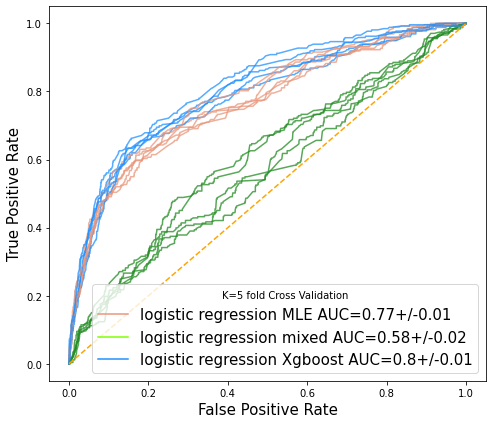

In [50]:
fig, ax = plt.subplots(figsize=(7, 6))

plt.plot([],[], color='darksalmon', label='logistic regression MLE AUC='+ str(np.mean(lr_auc).round(2))+ '+/-'+ str(np.std(lr_auc).round(2)))

plt.plot([],[], color='chartreuse', label='logistic regression mixed AUC='+ str(np.mean(mixed_auc).round(2))+ '+/-'+ str(np.std(mixed_auc).round(2)))

plt.plot([],[], color='dodgerblue', label='logistic regression Xgboost AUC='+ str(np.mean(xg_auc).round(2))+ '+/-'+ str(np.std(xg_auc).round(2)))
ax.legend(fontsize=15, title='K=5 fold Cross Validation') 

for k in np.arange(0, 5, 1):
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true=data[ycol].iloc[tests[k]], y_score=logreg[k])
    ax.plot(fpr, tpr, color='darksalmon', alpha=0.75, label='K={k} fold logistic regression MLE'.format(k=k+1))
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true=data[ycol].iloc[tests[k]], y_score=mixed[k])
    ax.plot(fpr, tpr, color='forestgreen', alpha=0.75, label='K={k} fold logistic regression mixed'.format(k=k+1))
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true=data[ycol].iloc[tests[k]], y_score=xgmod[k])
    ax.plot(fpr, tpr, color='dodgerblue', alpha=0.75, label='K={k} fold logistic regression Xgboost'.format(k=k+1))
    
ax.plot([0, 1], [0, 1], color='orange', linestyle='--')
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_ylabel('True Positive Rate', fontsize=15)
fig.tight_layout()
fig.savefig('roc.pdf', bbox_inches='tight')

In [58]:
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  BUFFY   No. Observations:                 8119
Model:                          Logit   Df Residuals:                     8103
Method:                           MLE   Df Model:                           15
Date:                Mon, 21 Sep 2020   Pseudo R-squ.:                  0.1802
Time:                        11:56:01   Log-Likelihood:                -2536.4
converged:                       True   LL-Null:                       -3094.1
Covariance Type:            nonrobust   LLR p-value:                2.467e-228
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Gender                               -0.0007      0.075     -0.009      0.993      -0.148       0.147
Q53_1                                -2.2472      0.087    -25.876      0.000      -2.417      -2.077
Q53_2                                 0.0836      0.077      1.080      0.280      -0.068       0.235
Q53_3                                -0.2752      0.081     -3.419      0.001      -0.433      -0.117
Q53_4                                 0.0651      0.104      0.626      0.531      -0.139       0.269
Q53_5                                -0.1478      0.103     -1.432      0.152      -0.350       0.054
Q53_6                                -0.4004      0.145     -2.757      0.006      -0.685      -0.116
Q53_7                                -0.0120      0.112     -0.107      0.915      -0.232       0.208
Q53_8                                 0.0066      0.118      0.056      0.955      -0.224       0.237
Race_Asian                            1.3670        nan        nan        nan         nan         nan
Race_Black                            1.0044        nan        nan        nan         nan         nan
Race_Hispanic/Latino                  0.3768        nan        nan        nan         nan         nan
Race_Not Reported                     1.3144        nan        nan        nan         nan         nan
Race_White                            1.6489        nan        nan        nan         nan         nan
Q15_4 year college                    2.7378        nan        nan        nan         nan         nan
Q15_Master's granting institution     1.2642        nan        nan        nan         nan         nan
Q15_PhD granting institution          1.7095        nan        nan        nan         nan         nan
=====================================================================================================
"""

In [59]:
results.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,2.3757,0.0367,,,
Gender,M,0.0022,0.0215,,,
Q53_1,M,-2.2467,0.0210,,,
Q53_2,M,0.0854,0.0221,,,
Q53_3,M,-0.2709,0.0216,,,
Q53_4,M,0.0783,0.0196,,,
Q53_5,M,-0.1405,0.0196,,,
Q53_6,M,-0.3853,0.0189,,,
Q53_7,M,-0.0102,0.0197,,,
Q53_8,M,0.0163,0.0192,,,


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

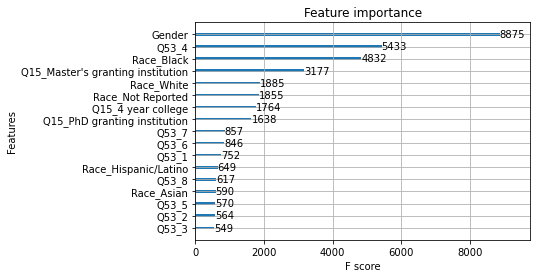

In [57]:
xgb.plot_importance(bst)

In [20]:
# races

In [21]:
# TODO : restructure data set so that
# 1. all column names have no spaces
# 2. the institution column is restructured to be 3 item categorical
# 3. input data into GLM model
# 4. add to ROC curves


In [22]:
# import statsmodels.genmod.bayes_mixed_glm as smgb

# def convert_data_for_mixed(data):
#     data.columns = [x.replace(' ', '_').replace("'", "").replace('/', '_').replace(' ', '_') for x in data.columns]
#     data['institution_type'] = (data['Q15_4_year_college'].apply(lambda x: '4year' if x==1 else '') + data["Q15_Masters_granting_institution"].apply(lambda x: 'masters' if x==1 else '') + data['Q15_PhD_granting_institution'].apply(lambda x: 'phd' if x==1 else ''))
#     return data

# def mixed_effects_model(data):
# #     data.columns = [x.replace(' ', '_').replace("'", "").replace('/', '_').replace(' ', '_') for x in data.columns]
# #     data['institution_type'] = (data['Q15_4_year_college'].apply(lambda x: '4year' if x==1 else '') + data["Q15_Masters_granting_institution"].apply(lambda x: 'masters' if x==1 else '') + data['Q15_PhD_granting_institution'].apply(lambda x: 'phd' if x==1 else ''))
#     data = convert_data_for_mixed(data)
#     random = {'a':'0 + C(institution_type)', 'b':'0 + C(institution_type)'}
#     formula = 'BUFFY ~ Gender + Q53_1 + Q53_1 + Q53_2 + Q53_3 + Q53_4 + Q53_5 + Q53_6 + Q53_7 + Q53_8 + Race_Asian + Race_Black + Race_Hispanic_Latino + Race_Not_Reported + Race_White'
    
#     model = smgb.BinomialBayesMixedGLM.from_formula(formula, random, data)
#     result = model.fit_vb()
#     return result

In [23]:
# results = mixed_effects_model(X_train.join(y_train))
# print(results.summary())
# metrics.roc_auc_score(y_true=y_test, y_score=results.predict(pd.get_dummies(X_test)))


In [24]:
# results.predict(pd.get_dummies(X_test))

In [25]:
# cols = ['Gender', 'Q53_1', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6', 'Q53_7', 'Q53_8', 'Race_Asian', 'Race_Black', 'Race_Hispanic_Latino', 'Race_Not_Reported', 'Race_White', 'institution_type']
# convert_data_for_mixed(X_test)[cols]

In [26]:
# results.predict(convert_data_for_mixed(X_test)[cols])

In [27]:
# results = mixed_effects_model(X_train.join(y_train))
# print(results.summary())
# metrics.roc_auc_score(y_true=y_test, y_score=results.predict(X_test))


In [28]:
# random = {"a": '0 + Gender', "b": '0 + Gender'} 
# mod = smgb.BinomialBayesMixedGLM.from_formula('BUFFY ~ Gender + Q53_1', random, data)
# result = model.fit_vb()

In [29]:
# result.summary()

In [30]:
# metrics.roc_auc_score(y_true=y_test, y_score=result.predict(X_test[['Gender', 'Q53_1']]))

In [31]:
# [x.replace(' ', '_').replace("'", "") for x in X_train.columns]

In [32]:
# X_train.columns

In [33]:
# X_train[['Q15_4 year college', "Q15_Master's granting institution", 'Q15_PhD granting institution']]

In [34]:
# (X_train['Q15_4 year college'].apply(lambda x: '4year' if x==1 else '') + X_train["Q15_Master's granting institution"].apply(lambda x: 'masters' if x==1 else '') + X_train['Q15_PhD granting institution'].apply(lambda x: 'phd' if x==1 else ''))#.unique()

In [35]:
# X_train[(X_train['Q15_4 year college']==0) & (X_train["Q15_Master's granting institution"]==1) & (X_train['Q15_PhD granting institution']==0)]

In [36]:
# students[students.Q15!='2 year college'].dropna(subset=['Q15'])

In [37]:
# e.cis['Q15'].unique()

In [38]:
# students